In [35]:
import numpy as np
import pandas as pd
import scipy
from datetime import datetime
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline

# Unemployment Rate Time Series

In this exercise, we are going to take a look at the unemployment rate data from 1948 to 2019 and attempt to build an ARIMA model.

In [36]:
# import data
unemp_data = pd.read_csv('../../../Data/unemp_rate.csv')
unemp_data.head()


,DATE,UNRATE
0,1948-01-01,3.4
1,1948-02-01,3.8
2,1948-03-01,4.0
3,1948-04-01,3.9
4,1948-05-01,3.5


In [37]:
# check for any null values
unemp_data.isnull().values.any()


False

In [38]:
# convert the DATE column to pandas datetime object
unemp_data['conv'] = pd.to_datetime(unemp_data.DATE)
unemp_data.head()

,DATE,UNRATE,conv
0,1948-01-01,3.4,1948-01-01
1,1948-02-01,3.8,1948-02-01
2,1948-03-01,4.0,1948-03-01
3,1948-04-01,3.9,1948-04-01
4,1948-05-01,3.5,1948-05-01


### Stationarity  
Since one of the assumptions made when building an ARIMA model is that the data is stationary, we will plot the series to see if it is, and apply differecing to it if it is not.

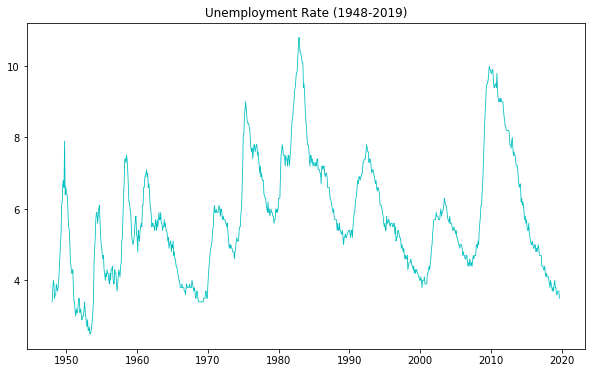

In [39]:
plt.figure(figsize=(10, 6))
plt.plot('conv', 'UNRATE', data=unemp_data, color='c', linewidth=0.8)
plt.title('Unemployment Rate (1948-2019)')
plt.show()

This definitely isn't very stationary. Let's apply the first order of differecing and see what happens.

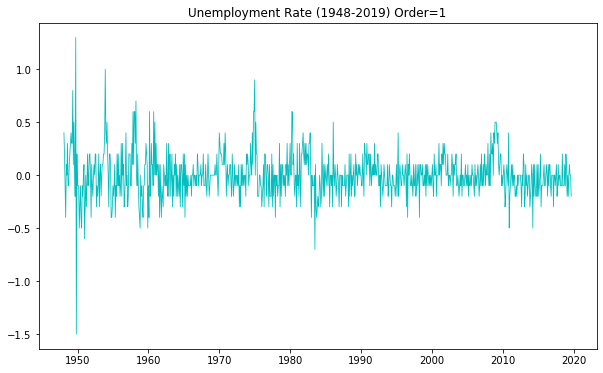

In [40]:
unemp_data['diff_1'] = unemp_data.UNRATE - unemp_data.UNRATE.shift()
plt.figure(figsize=(10, 6))
plt.plot('conv', 'diff_1', data=unemp_data, color='c', linewidth=0.8)
plt.title('Unemployment Rate (1948-2019) Order=1')
plt.show()

The first order differecing plot does look much better. Seems to be pretty stationary but let's go one more level to see if it improves.

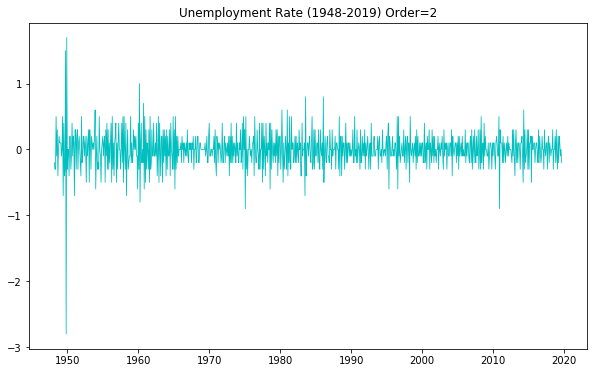

In [41]:
# let's try differencing one more order
unemp_data['diff_2'] = unemp_data.diff_1 - unemp_data.diff_1.shift()
plt.figure(figsize=(10, 6))
plt.plot('conv', 'diff_2', data=unemp_data, color='c', linewidth=0.8)
plt.title('Unemployment Rate (1948-2019) Order=2')
plt.show()

Second order does looks very stationary, but we need to plot the pacf of each of the series to find out which would work better.

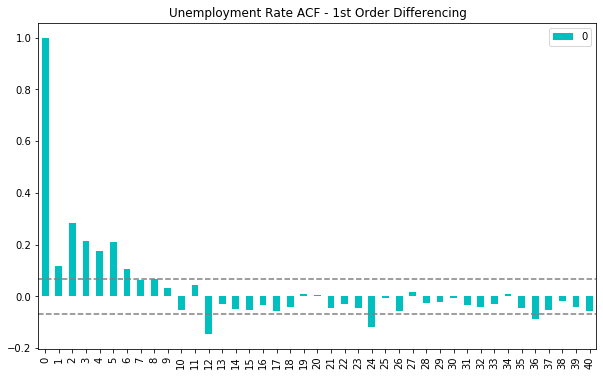

In [53]:
from statsmodels.tsa.stattools import pacf, acf
a = acf(unemp_data.diff_1[1:])
x_acf = pd.DataFrame(a)
x_acf.plot(kind='bar', figsize=(10, 6), color='c')
plt.axhline(y=-1.96/np.sqrt(len(unemp_data.diff_1[1:])),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(unemp_data.diff_1[1:])),linestyle='--',color='gray')
plt.title("Unemployment Rate ACF - 1st Order Differencing")
plt.show()

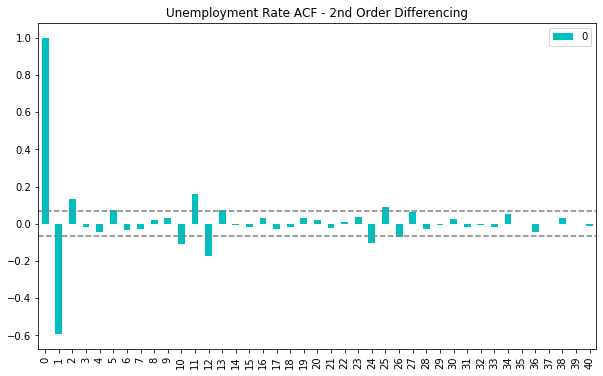

In [54]:
a = acf(unemp_data.diff_2[2:])
x_acf = pd.DataFrame(a)
x_acf.plot(kind='bar', figsize=(10, 6), color='c')
plt.axhline(y=-1.96/np.sqrt(len(unemp_data.diff_1[1:])),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(unemp_data.diff_1[1:])),linestyle='--',color='gray')
plt.title("Unemployment Rate ACF - 2nd Order Differencing")
plt.show()

The autocorrelation function plot for the second order differencing shows that the first term is highly negative, meaning that this series is most likely over-differenced. So, even though the second order differencing plot seems more stationary, we will start with the first order, or I=1.

### Auto Regression
Next term we will work on discovering is the auto regression. We will do this by plotting the partial autocorrelation function plot.

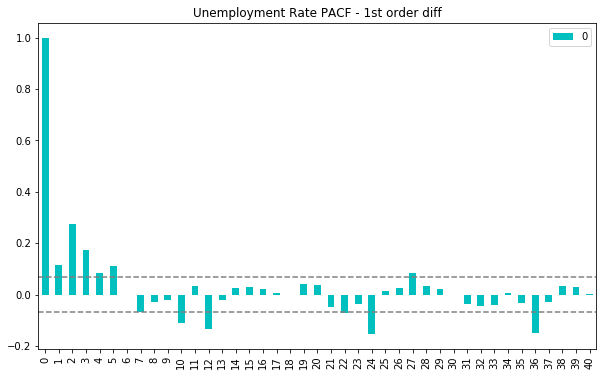

In [56]:
p = pacf(unemp_data.diff_1[1:])
x_pacf = pd.DataFrame(p)
x_pacf.plot(kind='bar', figsize=(10, 6), color='c')
plt.axhline(y=-1.96/np.sqrt(len(unemp_data.diff_1[1:])),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(unemp_data.diff_1[1:])),linestyle='--',color='gray')
plt.title("Unemployment Rate PACF - 1st order diff")
plt.show()

All the lags upto 5 appears above the significance line, so we will set the p term as 5.

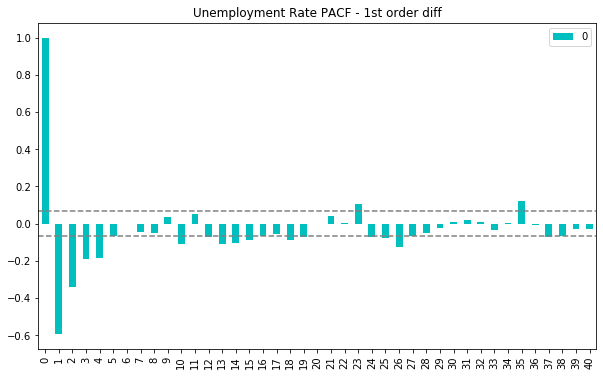

In [65]:
p = pacf(unemp_data.diff_2[2:])
x_pacf = pd.DataFrame(p)
x_pacf.plot(kind='bar', figsize=(10, 6), color='c')
plt.axhline(y=-1.96/np.sqrt(len(unemp_data.diff_2[2:])),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(unemp_data.diff_2[2:])),linestyle='--',color='gray')
plt.title("Unemployment Rate PACF - 1st order diff")
plt.show()

### Moving Average
The moving average term is easily gathered since we have already plotted the ACF plot for the first order differenced series. We can see from that plot that lags are significant up until 6, so we will set the q-term at 6 for now.

In [62]:
from statsmodels.tsa.arima_model import ARIMA
model1 = ARIMA(unemp_data.UNRATE, order=(5, 1, 6))
model_fit = model1.fit()
print(model_fit.summary())
print('Residuals Description')
print(model_fit.resid.describe())

/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                             ARIMA Model Results                              
Dep. Variable:               D.UNRATE   No. Observations:                  860
Model:                 ARIMA(5, 1, 6)   Log Likelihood                 211.967
Method:                       css-mle   S.D. of innovations              0.189
Date:                Tue, 08 Oct 2019   AIC                           -397.935
Time:                        00:44:55   BIC                           -336.094
Sample:                             1   HQIC                          -374.260
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0007      0.013      0.050      0.960      -0.026       0.027
ar.L1.D.UNRATE     0.8682      0.107      8.122      0.000       0.659       1.078
ar.L2.D.UNRATE     0.2652      0.036

The second MA term's coefficient is very small and the p-value is high and hence insignificant. Let's try ARIMA(5, 1, 5) and see if the model improves.

In [64]:
model2 = ARIMA(unemp_data.UNRATE, order=(5, 1, 5))
model_fit = model2.fit()
print(model_fit.summary())
print('Residuals Description')
print(model_fit.resid.describe())

                             ARIMA Model Results                              
Dep. Variable:               D.UNRATE   No. Observations:                  860
Model:                 ARIMA(5, 1, 5)   Log Likelihood                 203.006
Method:                       css-mle   S.D. of innovations              0.191
Date:                Tue, 08 Oct 2019   AIC                           -382.012
Time:                        00:45:37   BIC                           -324.929
Sample:                             1   HQIC                          -360.159
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0006      0.011      0.052      0.958      -0.022       0.023
ar.L1.D.UNRATE    -0.1882      0.198     -0.951      0.342      -0.576       0.200
ar.L2.D.UNRATE     0.6206      0.081

That didn't really work. Since we had some questions about which differenced series was better to build our model with so let's see if I=2 does any better.

In [66]:
model = ARIMA(unemp_data.UNRATE, order=(4, 2, 2))
model_fit = model.fit()
print(model_fit.summary())
print('Residuals Description')
print(model_fit.resid.describe())

                             ARIMA Model Results                              
Dep. Variable:              D2.UNRATE   No. Observations:                  859
Model:                 ARIMA(4, 2, 2)   Log Likelihood                 159.999
Method:                       css-mle   S.D. of innovations              0.201
Date:                Tue, 08 Oct 2019   AIC                           -303.998
Time:                        00:48:26   BIC                           -265.951
Sample:                             2   HQIC                          -289.431
                                                                              
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.0002      0.002     -0.102      0.919      -0.004       0.004
ar.L1.D2.UNRATE    -0.6915      0.529     -1.308      0.191      -1.728       0.345
ar.L2.D2.UNRATE    -0.2342      

In [26]:
model = ARIMA(unemp_data.UNRATE, order=(0,1,0))
model_fit = model.fit()
print(model_fit.summary())
print('Residuals Description')
print(model_fit.resid.describe())

                             ARIMA Model Results                              
Dep. Variable:               D.UNRATE   No. Observations:                  860
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 129.373
Method:                           css   S.D. of innovations              0.208
Date:                Mon, 07 Oct 2019   AIC                           -254.746
Time:                        13:07:26   BIC                           -245.232
Sample:                             1   HQIC                          -251.103
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001      0.007      0.016      0.987      -0.014       0.014
Residuals Description
count    8.600000e+02
mean     1.519754e-09
std      2.082970e-01
min     -1.500116e+00
25%     -1.001163e-01

The AIC for ARIMA(5,1,6) is much lower than that for ARIMA(4,2,2). Let's see just how much it is better by calculating the AIC ratio.

In [67]:
# exp((AIC(min) - AIC(n))/2)
print(np.exp((-398+304)/2))

3.873997628687187e-21


So the probability that we lost less information with ARIMA(4,2,2) compared with ARIMA(5,1,6) is 